In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['data']


## Ακολουθεί κώδικας από προηγούμενα notebooks

In [14]:
import copy
import gzip
import torch
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader

def torch_train_val_split(
        dataset, batch_train, batch_eval,
        val_size=.2, test_size=.3, shuffle=True, seed=42): # We defined an extra parameter test_size in order to create a labeled test set (from the train data)
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    test_split = int(np.floor(test_size * val_split))
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    
    train_indices = indices[val_split:]
    val_indices = indices[:val_split]
    test_indices = val_indices[:test_split]
    val_indices = val_indices[test_split:]
    
    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset,
                              batch_size=batch_train,
                              sampler=train_sampler)
    val_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=val_sampler)
    test_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=test_sampler)
    
    return train_loader, val_loader, test_loader


def read_spectrogram(spectrogram_file, chroma=True):
    with gzip.GzipFile(spectrogram_file, 'r') as f:
        spectrograms = np.load(f)
    # spectrograms contains a fused mel spectrogram and chromagram
    # Decompose as follows
    return spectrograms.T


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])

        
class PaddingTransform(object):
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[:self.max_length]

        if len(s) < self.max_length:
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1

        
class SpectrogramDataset(Dataset):
    def __init__(self, path, class_mapping=None, train=True, max_length=-1):
        self.train = train
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        if train:
            self.index = os.path.join(path, "{}_labels.txt".format(t))
            self.files, self.labels = self.get_files_labels(self.index, class_mapping)
            self.feats = [read_spectrogram(os.path.join(p, f)) for f in self.files]
            self.feat_dim = self.feats[0].shape[1]
            self.lengths = [len(i) for i in self.feats]
            self.max_length = max(self.lengths) if max_length <= 0 else max_length
            self.zero_pad_and_stack = PaddingTransform(self.max_length)
            self.label_transformer = LabelTransformer()
            self.labels = np.array(self.labels)
        else: # the labels for the test dataset were not provided
            self.files = [f for f in os.listdir('../input/data/data/multitask_dataset_beat/test')]
            self.ids = [int(str(f).rstrip().split('.')[0]) for f in self.files]
            self.feats = [read_spectrogram(os.path.join('../input/data/data/multitask_dataset_beat/test', f)) for f in self.files]
            self.feat_dim = self.feats[0].shape[1]
            self.lengths = [len(i) for i in self.feats]
            self.max_length = max(self.lengths) if max_length <= 0 else max_length
            self.zero_pad_and_stack = PaddingTransform(self.max_length)


    def get_files_labels(self, txt, class_mapping): # slightly changed (split with comma, labels now contain 3 floats)
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split(',') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            label = [float(l[1]), float(l[2]), float(l[3])]
            files.append(l[0] + '.fused.full.npy.gz')
            labels.append(label)
        return files, labels

    def __getitem__(self, item):
        if self.train:
            l = min(self.lengths[item], self.max_length)
            return self.zero_pad_and_stack(self.feats[item]), self.labels[item], l
        else:
            return self.ids[item], self.zero_pad_and_stack(self.feats[item]) # there are no labels for competition data
        
    def __len__(self):
        return len(self.files) # slightly changed
      
if __name__ == '__main__':
    specs = SpectrogramDataset('../input/data/data/multitask_dataset_beat', train=True, max_length=-1)
    train_loader, val_loader, test_loader = torch_train_val_split(specs, 32 ,32, val_size=.4)
    competition = DataLoader(SpectrogramDataset('../input/data/data/multitask_dataset_beat', train=False, max_length=-1))
    #test_specs = [read_spectrogram(os.path.join('../input/data/data/multitask_dataset_beat/test', f))for f in os.listdir('../input/data/data/multitask_dataset_beat/test')]

# Resnet
## Στα παρακάτω υλοποιούμε ένα basic transfer learning, μέσω των pretrained models που παρέχει το torchvision.
### Πιο συγκεκριμένα, αλλάξαμε λίγο το τελευταίο στάδιο του δικτύου ώστε να υπολογίζει μία τιμή για κάθε sample και ορίσαμε να αλλάξουν τα βάρη μονάχα αυτόυ του layer, ώστε να γίνει το feature extraction απ' το pretrained model. Επίσης, μιας και το resnet δέχεται είσοδο $224 \times 224, 3$ καναλιων, κάπως αυθαίρετα κάναμε expand τα features σε τόσες διαστάσεις με μηδενικά (εξ' ου και ο προσδιορισμός basic) και επανάβαμε την ίδια εικόνα και στα 3 κανάλια. Εναλλακτικά, θα μπορούσαμε να κάνουμε κάποιο πιο έξυπνο oversample ή ακόμα καλύτερα να ορίσουμε ένα CNN με έξοδο 3 κανάλια κατάλληλων διαστάσεων και να το εκπαιδεύσουμε και αυτό κατά το fine tuning (δεν υλοποιήθηκε). Χρησημοποιήσαμε την δοκιμασμένη απ' τα προηγούμενα notebooks Smooth L1 Loss που φαίνεται να λειτουργεί καλύτερα για το συγκεκριμένo task. Στόχος της εκπαίδευσης είναι το regression στον άξονα του valency, δηλαδή αυτόν με τις χειρότερες επιδόσεις στην μέθοδ με τα CNNs. Ένα κομμάτι του κώδικα βασίζεται στο [tutorial](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html) .

In [15]:
import torch.nn as nn
torch.set_default_tensor_type(torch.DoubleTensor)
import scipy.stats as scp

def evalCNN(model, loss_function, data_loader, axis, test=False):
    valscores = gold = torch.tensor([])
    ValLoss = 0
    model.eval()
    for feats, labels, lens in data_loader:
        with torch.no_grad():
            feats = feats.view(feats.shape[0], 1, feats.shape[2], feats.shape[1])
            feats = feats.expand(-1, 3, -1, -1)
            feats_c = torch.zeros(feats.shape[0], 3, 224, 224)
            feats_c[:, :, :feats.shape[2], :feats.shape[3]] = feats
            scores = model(feats_c)
            valscores = torch.cat((valscores, scores.view(-1)))
            gold = torch.cat((gold, labels[:,axis]))
            if test==True and ValLoss==0: # print the 1st batch
                plt.plot(labels[:,axis].numpy(), 'ro', scores.view(-1).numpy(), 'x')
                plt.ylim(0, 1)
                plt.show()
            ValLoss += loss_function(scores.view(-1), labels[:,axis])
    metric, _ = scp.spearmanr(valscores.detach().numpy(), gold)
    
    return metric, ValLoss
            
def trainCNN(model, loss_function, optimizer, epochs, axis):
    best_metric = 0
    for epoch in range(epochs):
        model.train()
        TrainLoss = 0
        for feats, labels, lens in (train_loader):
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()
            optimizer.zero_grad()

            # Step 3. Run our forward pass.
            feats = feats.view(feats.shape[0], 1, feats.shape[2], feats.shape[1])
            feats = feats.expand(-1, 3, -1, -1)
            #print(feats.shape)
            feats_c = torch.zeros(feats.shape[0], 3, 224, 224)
            #print(feats_c.shape)
            feats_c[:, :, :feats.shape[2], :feats.shape[3]] = feats
            pred_labels = model(feats_c)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(pred_labels.view(-1), labels[:,axis])
            TrainLoss += loss
            loss.backward()
            optimizer.step()
        
        metric, ValLoss = evalCNN(model, loss_function, val_loader, axis)
        print("Epoch: " + str(epoch) + " || train loss: " + str(TrainLoss) + " & val loss: " + str(ValLoss))
        print("Metric is: " + str(metric))
        if metric > best_metric:
            best_metric = metric
            best_model = copy.deepcopy(model)
            
    return best_model

Params to learn:
	 fc.weight
	 fc.bias
Epoch: 0 || train loss: tensor(3.8427, grad_fn=<AddBackward0>) & val loss: tensor(1.4955)
Metric is: 0.0020979586813876655
Epoch: 1 || train loss: tensor(1.9165, grad_fn=<AddBackward0>) & val loss: tensor(1.0355)
Metric is: 0.05695982045818336
Epoch: 2 || train loss: tensor(1.5437, grad_fn=<AddBackward0>) & val loss: tensor(0.9960)
Metric is: 0.09349356634212452
Epoch: 3 || train loss: tensor(1.3101, grad_fn=<AddBackward0>) & val loss: tensor(1.1214)
Metric is: 0.11941290104248699
Epoch: 4 || train loss: tensor(1.4607, grad_fn=<AddBackward0>) & val loss: tensor(0.9897)
Metric is: 0.1394649284800014


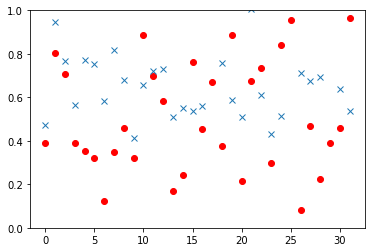

In [16]:
from torchvision import models

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

cheat_model = models.resnet18(pretrained=True)
set_parameter_requires_grad(cheat_model, True)
cheat_model.fc = nn.Linear(512, 1)

params_to_update = cheat_model.parameters()
print("Params to learn:")
if True:
    params_to_update = []
    for name,param in cheat_model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in cheat_model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)
loss_function = nn.MSELoss()
cheatcode = trainCNN(cheat_model, loss_function, optimizer, 5, 0)

metric, _ = evalCNN(cheat_model, loss_function, test_loader, 0, test=True)